## Introdução

O objetivo deste notebook é treinar um modelo pix2pix para tradução de imagens.

Queremos gerar imagens de desenho animado de pessoas a partir de uma foto real.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import cv2
import os

In [4]:
from keras.layers import Conv2D, Conv2DTranspose, Input,Dropout, ReLU,BatchNormalization,Concatenate,LeakyReLU,Identity
from keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [5]:
!wget -nc https://github.com/Sxela/face2comics/releases/download/v2.0.0/face2comics_v2.0.0_by_Sxela_faces.tar
!tar --skip-old-files -xf face2comics_v2.0.0_by_Sxela_faces.tar

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
File ‘face2comics_v2.0.0_by_Sxela_faces.tar’ already there; not retrieving.

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
tar: A lone zero block at 2696643


In [6]:
!wget -nc https://github.com/Sxela/face2comics/releases/download/v2.0.0/face2comics_v2.0.0_by_Sxela_comics.tar
!tar --skip-old-files -xf face2comics_v2.0.0_by_Sxela_comics.tar

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
File ‘face2comics_v2.0.0_by_Sxela_comics.tar’ already there; not retrieving.

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
tar: A lone zero block at 1904148


Apos rodar as linhas acima, devem aparecer 2 diretorios novos:

```
    * comics/
    * faces/
```

In [7]:
y_folder = "comics"
x_folder = "faces"

Todas as imagens de rostos reais em ```faces/``` possuem um equivalente em ```comics/```.

Os pares de treinamento todos possuem o mesmo nome de arquivo.

In [8]:
#Precisamos gerar os caminhos para as imagens, tanto para faces/ quanto para comics/
x_files = sorted([os.path.join(x_folder, fname) for fname in os.listdir(x_folder) if fname.endswith(".jpg")])
y_files = sorted([os.path.join(y_folder, fname) for fname in os.listdir(y_folder) if fname.endswith(".jpg")])
#Teste de sanidade para garantir que temos o mesmo número de instâncias
assert len(x_files) == len(y_files), "Number of files in each folder must be the same"

Como as imagens são relativamente grandes e a GPU é relativamente fraca, redimensionaremos as imagens para um tamanho gerenciável.

In [9]:
img_size = 128 # Variavel usada para reescalar as imagens, alem a entrada dos definir os modelos

In [10]:
# Funcao para carregar e pre-processar as imagens
def load_image(file_path):
    image = tf.io.read_file(file_path)
    #Todas as imagens sao RGB
    image = tf.image.decode_jpeg(image, channels=3)
    #Resize para manter o tamanho constante
    image = tf.image.resize(image, [img_size, img_size])
    #Como no paper original, o generador constroi imagens no intervalo [-1...1]
    #Assim, para manter as imagens comparaveis, precisamos transformar o intervalo [0...255] -> [-1...1]
    image = tf.cast(image, tf.float32)
    # [0...255]  - 127.5 = [-127,5 .... 127,5]
    # [-127,5 .... 127,5] / 127.5  -> [-1...1]
    image = (image - 127.5) / 127.5
    return image

# Function to load and preprocess paired images
def load_pair(x_path, y_path):
    x_image = load_image(x_path)
    y_image = load_image(y_path)
    return x_image, y_image

Com os dados carregados, podemos ver um exemplo de par a ser aprendido.

2024-08-05 10:32:47.731096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13867 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


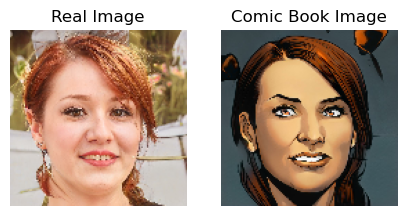

In [11]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow((load_image(x_files[0]) +1)/2)
plt.title("Real Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow((load_image(y_files[0]) +1)/2)
plt.title("Comic Book Image")
plt.axis('off')
plt.show()

## Separacao em Treino e Teste

Nesse momento, a separacao tem o objetivo de atestar a capacidade de generalizacao do modelo

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(x_files, y_files, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=42)

len(X_train),len(X_val),len(X_test)

(7000, 1000, 2000)

In [14]:
def create_dataset(x_files, y_files,batch_size=8,is_train=False):
    # Com base nos arquivos
    dataset = tf.data.Dataset.from_tensor_slices((x_files, y_files))

    # Carregue os dados com a funcao load_pair(x,y)
    # O map aqui eh usado para aplicar a funcao sobre todos os dados,
    # tf.py_function faz a execucao ser mais eficiente
    dataset = dataset.map(lambda x, y: tf.py_function(load_pair, [x, y], [tf.float32, tf.float32]))

    # Para o dataset de treino, queremos que os dados sejam aleatorizados a cada passada
    # A prob de um elemento qualquer ser escolhido ao caso eh de 1/1000
    # O ideal seria 1/len(X)
    # Entretanto, para escolher as amostras aleatoriamente, eh preciso preencher um buffer de tamanho len(X)
    # Isso faz que o treinamento seja extremamente lento, pois o programa leva varias iteracoes para preencher o buffer de tamanho len(x)
    # A escolha do buffer_size = 1000 suaviza isso, sem prejudicar a premissa da aleatoriedade.
    if is_train: dataset = dataset.shuffle(1000)

    # Batch e prefetch sao APIs para otimizar o uso do dataset 
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, Y_train,is_train=True)
test_dataset = create_dataset(X_test, Y_test)
val_dataset = create_dataset(X_val, Y_val)

## Definicao dos Modelos

Aqui, instanciamos a arquitetura dos modelos e as funcoes de perda

O RMSE (Raiz do MSE) e o PSNR sao funcoes usadas para medir o desempenho da reconstrucao feita pelo gerador

Quando **menor** o RMSE melhor.

Quanto **maior** o PNSR melhor.

In [15]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

Foram usadas as mesmas abstracoes que o paper original

CK: sao camadas sequenciais ```Convolution-BatchNorm-ReLu```

CDK:sao camadas sequenciais  ```Convolution-BatchNormDropout-ReLU```
<hr>
Todas com filtro 4x4 e stride 2. Ambas camadas podem ser downsample ou upsample, a depende do parametro.

Em caso de upsampling, trocamos ```Conv2D -> Conv2DTranspose```.

Algumas camadas podem ser ReLU ou LeakyReLU, isso tambem eh passado como parametro.

Por fim, nem toda camada aplica ```BatchNormalization```.

In [16]:
#Camada Convolution-BatchNorm-ReLu
def CK(filters, kernel_size=(4, 4), strides=(2, 2), padding='same', use_batch_norm=True, downsample=True):
    '''
        filters: quantidade de filtros
        kernel_size 4x4 | strides 2x2 | padding same | sao constantes durante o codigo
        use_batch_norm ->   indica quando devemos usar BatchNormalization, em caso de negativo, a camada se torna a Identidade
        downsample ->       indica se a dimensao deve aumentar ou diminuir 
    '''

    # Esse chavemento usando  if ternario serve para selecionar as camadas com base nos atributos
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = LeakyReLU(0.2)       if downsample       else ReLU()
    # alpha de 0.2 na LeakyReLU foi definido no paper original

    # Com o chaveamento pronto, a camada pode ser montada sequencialmente
    def layer(x):
        x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
        x = norm()(x)
        x = actf(x)
        return x
    return layer

def CDK(filters, kernel_size=(4, 4), strides=(2, 2), padding='same', use_batch_norm=True, downsample=True,dropout_rate=0.5):
    '''
        filters: quantidade de filtros
        kernel_size 4x4 | strides 2x2 | padding same | dropout_rate 0.5 | sao constantes durante o codigo
        use_batch_norm ->   indica quando devemos usar BatchNormalization, em caso de negativo, a camada se torna a Identidade
        downsample ->       indica se a dimensao deve aumentar ou diminuir 
    '''
    # Esse chavemento usando  if ternario serve para selecionar as camadas com base nos atributos
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = ReLU()
    # alpha de 0.2 na LeakyReLU foi definido no paper original

    # Com o chaveamento pronto, a camada pode ser montada sequencialmente
    def layer(x):
        x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
        x = norm()(x)
        x = Dropout(dropout_rate)(x) # Unica diferenca entre CK e CDK
        x = actf(x)
        return x
    return layer


In [17]:
def generator(input_nc, output_nc, ngf, num_blocks=1, num_downsample=3):
    # Aqui, definimos o modelo gerador
    
    # Ele deve receber uma imagem (img_size,img_size,input_nc)
    inputs = Input(shape=(img_size, img_size, input_nc))

    # --------------- START ENCODER --------------------------

    x = inputs

    # Uma convolucao eh aplicada inicialmente sem o batch_norm
    x = CK(ngf,use_batch_norm=False)(x)
    # img_shape = img_size/2,img_size/2,ngf

    # Aqui implementamos o caminho onde a dimensao da imagem vai diminuindo
    #Armazenamos as skip connections
    skips = []
    for i in range(num_downsample + num_blocks - 1):
        # Como o numero de filtros vai aumentando exponencialmente, existe um momento em que o crescimento eh cessado e a qtd se torna constante
        # Este e o momento em que i+1 >= num_downsample
        # A partir dai, o numero de filtros nao diminui
        expo = min(i+1,num_downsample)
        # Aplicamos convolucao com o numero de filtros escolhido
        x = CK(ngf*(2**(expo)))(x)
        # Guardamos a coneccao
        skips.append(x)
    
    # --------------- FIM   ENCODER --------------------------
    '''
    Aqui, a imagem esta no formato:
    img_shape = img_size/(num_downsample + num_blocks),img_size/(num_downsample + num_blocks),ngf*(2**(expo))
    
    '''
    # --------------- START DECODER --------------------------

    # As conexoes sao processadas de tras pra frente, ja que a ultima skip gerada vai se ligar com a primeira camada do decoder
    skips = list(reversed(skips))

    # No paper original, as num_blocks - 1 conexoes que mantem o numero de filtros constantes devem se ligar em camadas com dropout
    for skip in skips[:num_blocks-1]:
        # Primeiro juntamos as conexoes, 
        # aqui a ordem importa, se fizermos a convolucao primeiro, as imagens terao resolucao diferente.
        # Isso pode ser resolvido colocando mais uma convolucao entre o encoder e o decoder
        x = Concatenate()([x, skip])
        x = CDK(ngf*(2**(num_downsample)),downsample=False)(x)
        # Atencao no downsample = False, fazendo a camada aumentar a resolucao da imagem

    # Para as skips que sobraram, devemos conecta-las a camadas sem dropout
    for skip in skips[num_blocks-1:]:
        x = Concatenate()([x, skip])
        x = CK(ngf * (2 ** i),downsample=False)(x)
    
    #    img_shape = img_size/(2),img_size/(2),ngf*(2**(expo))
    # --------------- FIM   DECODER --------------------------

    # Por fim, uma ultima convolucao com TanH para gerar o resultado final
    # Numero de canais = output_nc  = 3 = RGB
    output = Conv2DTranspose(output_nc, (4, 4), activation='tanh',padding="same",strides=(2, 2))(x)
    return Model(inputs=inputs, outputs=output)

In [18]:
def discriminator(input_nc,output_nc, ngf, num_blocks=1, num_downsample=3):

    # O discriminador por sua vez, recebe a entrada e a saida do modelo, tentando assim decidir se aquilo 'e real ou nao
    inp = Input(shape=[img_size, img_size, input_nc], name='input_image')
    tar = Input(shape=[img_size, img_size, output_nc], name='target_image')

    # Concatenamos as duas imagens para fazer uma unica previsao
    x = Concatenate()([inp, tar])

    # Initial convolutional layers # SEM BATCH NORM !
    x = CK(ngf,use_batch_norm=False)(x)

    # Contracting path
    for i in range(num_downsample):
        x = CK(ngf*(2**(i+1)))(x)
    
    # Por fim, a patchGan gera uma classificao binaria por patch, o tamanho do patch eh definido pelo num_downsample. Quanto maior, menor a area de recepcao
    # Por exemplo num_downsample = 4 faz com que o discriminador classifique blocos de 16x16
    output = Conv2D(1, (4, 4), activation='sigmoid',padding="same",strides=(2, 2))(x)
    return Model(inputs=[inp, tar], outputs=output)

## Funcoes de perda

In [19]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

### Loss do discriminador

<hr>

$$
\text{discriminator\_loss} = \text{real\_loss} + \text{fake\_loss}
$$

onde

$$
\text{real\_loss} = \text{CrossEntropy}(\mathbf{1}, \text{real\_output})
$$
$$
\text{fake\_loss} = \text{CrossEntropy}(\mathbf{0}, \text{fake\_output})
$$
<hr>



$$
\text{generator\_loss} = \text{CrossEntropy}(\mathbf{1}, \text{fake\_output}) + \lambda\text{L1\_loss}
$$
onde:
$$
\text{L1\_loss} = \text{Mean}(|\text{real\_image} - \text{generated\_image}|)
$$

$\lambda$ eh o peso que a L1 loss tem na reconstrucao da imagem.
<hr>


In [20]:
# Essas funcoes espelham o que foi escrito acima
def discriminator_loss(real_output, fake_output):
    cross_entropy = BinaryCrossentropy(from_logits=False)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    cross_entropy = BinaryCrossentropy(from_logits=False)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def l1_loss(real_image, generated_image):
    return tf.reduce_mean(tf.abs(real_image - generated_image))

In [21]:
generator_optimizer = Adam(2e-4, beta_1=0.5,beta_2=0.999)
discriminator_optimizer = Adam(2e-4, beta_1=0.5,beta_2=0.999)
LAMBDA = 100
# O treinamento foi feito com Adam, usando os mesmos lr | b1 | b2 do paper orignal

# tf.function para tratar os gradientes separadamente
@tf.function
def train_step(input_image, target_image, generator, discriminator):
    '''
    Aqui eh definido um passo de treinamento
    '''

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Geramos a imagem fake
        generated_image = generator(input_image, training=True)
        # Fazemos o discriminador classificar tanto a imagem fake, quanto a imagem real
        real_output = discriminator([input_image, target_image], training=True)
        fake_output = discriminator([input_image, generated_image], training=True)
        # A partir disso, podemos calcula a loss do gerador, como escrita acima
        # LAMBDA = 100 igual o paper original
        gen_loss = generator_loss(fake_output) + LAMBDA*l1_loss(target_image, generated_image)
        # E a loss do discriminador
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculamos os gradientes para os dois modelos
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Um passo de gradiente descendente
    # Nota-se que quem executa a operacao sao os *optimizers*
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [22]:
# Funcao para calcular a loss e o rmse do gerador em cada passo
def evaluate_model(validation_dataset, generator_model, discriminator_model):
    # Initialize accumulators for metrics
    val_gen_loss_total = 0
    val_rmse_total = 0
    num_batches = 0

    # Iterate over the validation dataset
    for batch in validation_dataset:
        input_image, target_image = batch

        # Generate images using the generator model
        generated_image = generator_model(input_image, training=False)

        # Compute losses
        val_gen_loss = generator_loss(discriminator_model([input_image, target_image], training=False)) + LAMBDA*l1_loss(target_image, generated_image)
        val_rmse = rmse(target_image, generated_image)

        # Accumulate metrics
        val_gen_loss_total += val_gen_loss
        val_rmse_total += val_rmse
        num_batches += 1

    # Compute average metrics
    avg_val_gen_loss = val_gen_loss_total / num_batches
    avg_val_rmse = val_rmse_total / num_batches

    return avg_val_gen_loss, avg_val_rmse

In [23]:
# Uso
input_nc = 3  # Number of input channels (RGB)
output_nc = 3  # Number of output channels (RGB)
ngf = 64  # Number of generator filters in first conv layer
# Parametro ngf eh importante para regular o tamanho do modelo, como os pesos crescem exponencialemente, um alto ngf tras dificuldades na computacao

# Todos com 3 blocos e 4 downsamples
generator_model     = generator(input_nc, output_nc, ngf, num_blocks=3, num_downsample=4)
discriminator_model = discriminator(input_nc,output_nc, ngf, num_blocks=3, num_downsample=4)

# Instanciamos a loss de cada um
generator_model.compile(optimizer=generator_optimizer, loss=generator_loss)
discriminator_model.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)

In [24]:
generator_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           3136      ['input_1[0][0]']             
                                                                                                  
 identity (Identity)         (None, 64, 64, 64)           0         ['conv2d[0][0]']              
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)           0         ['identity[0][0]']            
                                                                                              

O gerador ficou com bastante parametros 409_744_067. Talvez nao rode no colab

Podemos ver sua arquitetura visualmente:

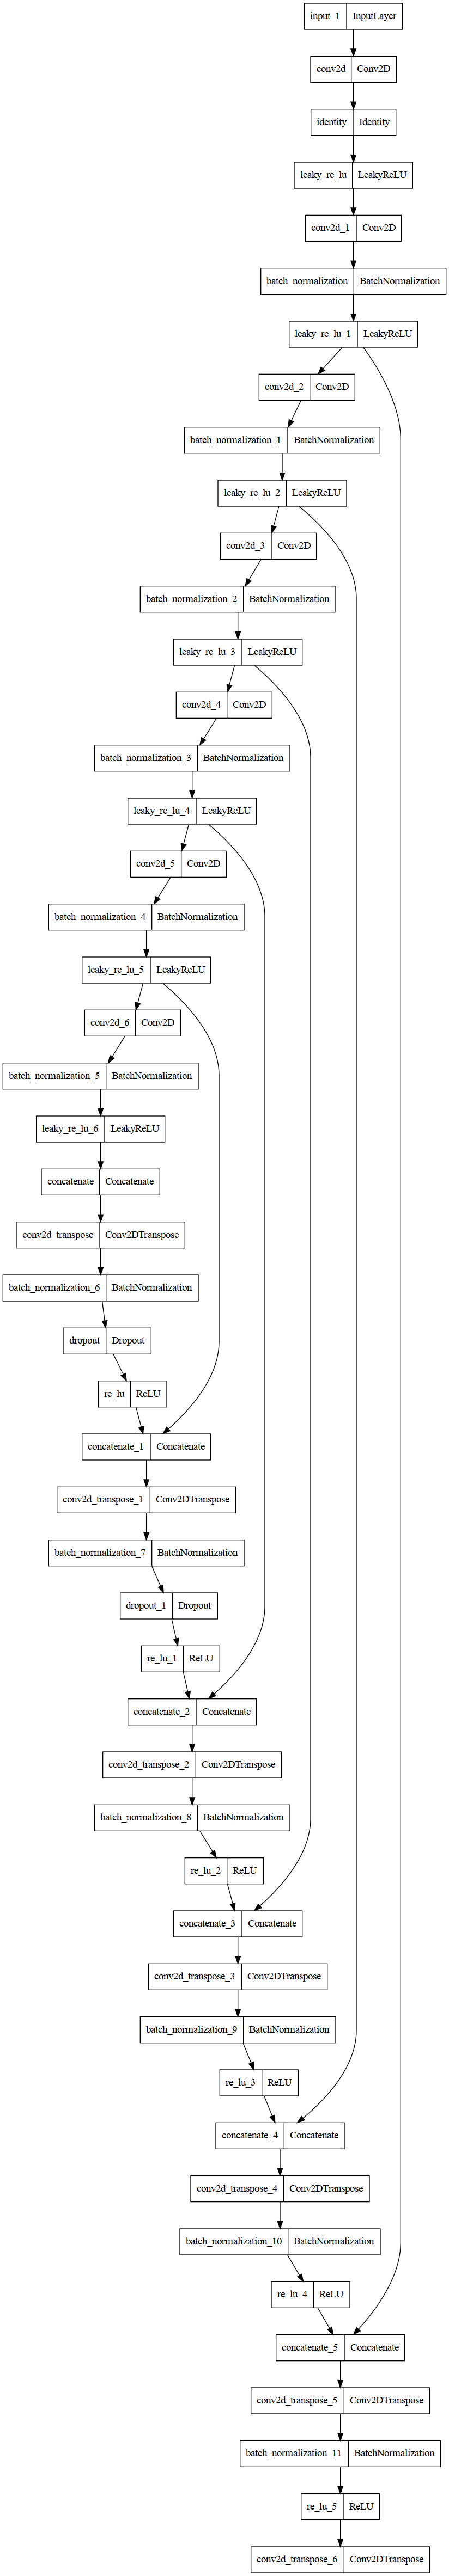

In [25]:
plot_model(generator_model)

In [26]:
discriminator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 concatenate_6 (Concatenate  (None, 128, 128, 6)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 conv2d_7 (Conv2D)           (None, 64, 64, 64)           6208      ['concatenate_6[0][0]'] 

O discriminator ficou com bastante parametros 11_173_313. Talvez nao rode no colab

Podemos ver sua arquitetura visualmente:

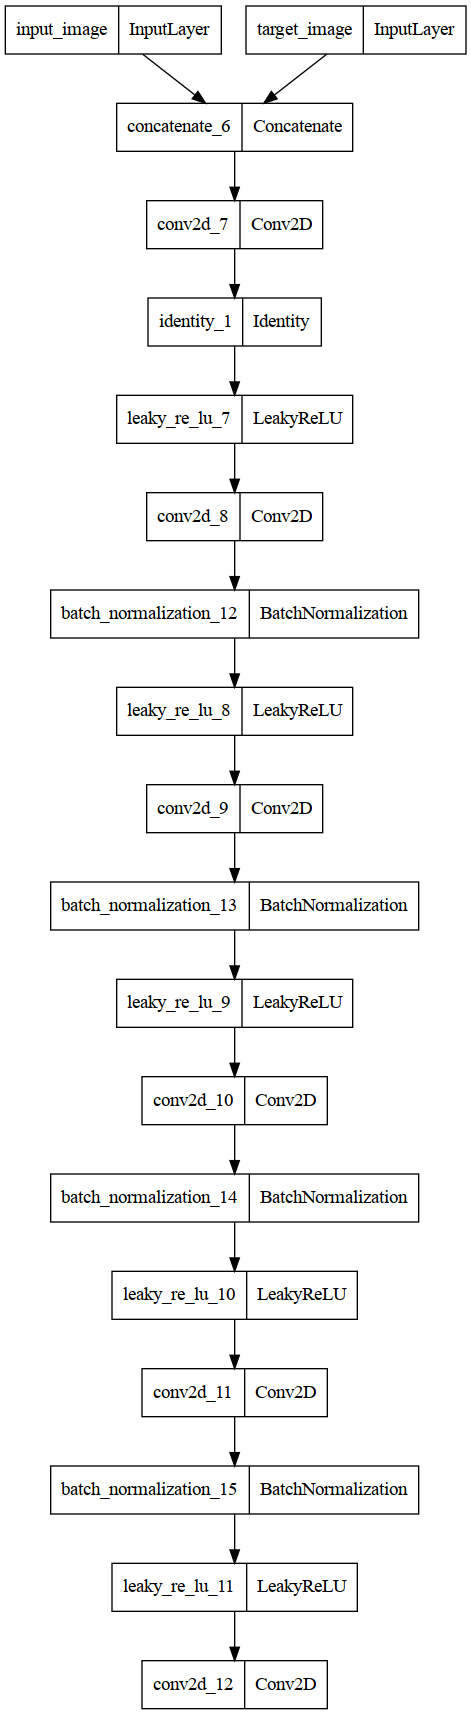

In [27]:
plot_model(discriminator_model)

## Treinamento

In [28]:
# Lists to store metrics
epochs_list = []
gen_losses = []
disc_losses = []
val_gen_losses = []
val_rmses = []
val_psnrs = []

In [29]:
# Training loop
epochs = 200
for epoch in range(epochs):
    #profilling
    gen_loss_total = 0
    disc_loss_total = 0
    num_batches = 0

    # Aplica-se um passo do treinamento em cada batch
    for batch in train_dataset:
        input_image, target_image = batch
        gen_loss, disc_loss = train_step(input_image, target_image, generator_model, discriminator_model)

        # Accumulate training losses
        gen_loss_total += gen_loss.numpy().item()
        disc_loss_total += disc_loss.numpy().item()
        num_batches += 1

    # Rodamos a avalia'cao no conjunto de validacao
    val_gen_loss, val_rmse = evaluate_model(val_dataset, generator_model, discriminator_model)

    # Compute average training losses
    gen_loss = gen_loss_total / num_batches
    disc_loss = disc_loss_total / num_batches

    # Collect stats
    epochs_list.append(epoch + 1)
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)
    val_gen_losses.append(val_gen_loss.numpy().item())
    val_rmses.append(val_rmse.numpy().item())


    # Profile
    print(f"Epoch {epoch+1}/{epochs} - Gen Loss: {gen_loss:.4f}, D Loss: {disc_loss:.4f}")
    print(f"Val Gen Loss: {val_gen_loss.numpy().item():.4f}, RMSE: {val_rmse.numpy().item():.4f}")
    print()

2024-08-05 10:33:00.417039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 623 of 1000
2024-08-05 10:33:06.805490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2024-08-05 10:33:10.155053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-05 10:33:10.775071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-08-05 10:33:16.411602: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5deb5b9e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-05 10:33:16.411633: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-05 1

Epoch 1/200 - Gen Loss: 30.8940, D Loss: 0.4284
Val Gen Loss: 26.7505, RMSE: 0.3753



2024-08-05 10:42:16.656061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 836 of 1000
2024-08-05 10:42:18.733519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 2/200 - Gen Loss: 32.0701, D Loss: 0.1641
Val Gen Loss: 27.5111, RMSE: 0.3645



2024-08-05 10:50:49.007861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 839 of 1000
2024-08-05 10:50:50.938977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 3/200 - Gen Loss: 27.4781, D Loss: 0.7951
Val Gen Loss: 23.7825, RMSE: 0.3521



2024-08-05 10:59:22.978643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 815 of 1000
2024-08-05 10:59:26.007252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 4/200 - Gen Loss: 26.0589, D Loss: 0.8330
Val Gen Loss: 25.8155, RMSE: 0.3690



2024-08-05 11:07:55.485590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 845 of 1000
2024-08-05 11:07:57.309945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 5/200 - Gen Loss: 25.4103, D Loss: 0.8431
Val Gen Loss: 23.6064, RMSE: 0.3603



2024-08-05 11:16:27.909544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 725 of 1000
2024-08-05 11:16:31.844775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 6/200 - Gen Loss: 24.7797, D Loss: 0.8658
Val Gen Loss: 22.8247, RMSE: 0.3565



2024-08-05 11:25:00.187574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 841 of 1000
2024-08-05 11:25:02.098530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 7/200 - Gen Loss: 24.1701, D Loss: 0.8433
Val Gen Loss: 22.0383, RMSE: 0.3474



2024-08-05 11:33:30.555758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 877 of 1000
2024-08-05 11:33:32.005169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 8/200 - Gen Loss: 23.6188, D Loss: 0.8430
Val Gen Loss: 24.7744, RMSE: 0.3737



2024-08-05 11:42:03.114184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 836 of 1000
2024-08-05 11:42:05.057812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 9/200 - Gen Loss: 23.0974, D Loss: 0.8231
Val Gen Loss: 21.5901, RMSE: 0.3420



2024-08-05 11:50:33.602655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 856 of 1000
2024-08-05 11:50:35.326211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 10/200 - Gen Loss: 22.4600, D Loss: 0.8094
Val Gen Loss: 20.4708, RMSE: 0.3299



2024-08-05 11:59:04.631961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 756 of 1000
2024-08-05 11:59:07.688237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 11/200 - Gen Loss: 22.1859, D Loss: 0.7593
Val Gen Loss: 21.6466, RMSE: 0.3440



2024-08-05 12:07:34.106538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 875 of 1000
2024-08-05 12:07:35.562071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 12/200 - Gen Loss: 21.9780, D Loss: 0.7187
Val Gen Loss: 21.8607, RMSE: 0.3415



2024-08-05 12:16:02.470297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 860 of 1000
2024-08-05 12:16:04.237273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 13/200 - Gen Loss: 21.5888, D Loss: 0.6940
Val Gen Loss: 20.3564, RMSE: 0.3293



2024-08-05 12:24:33.802954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 855 of 1000
2024-08-05 12:24:35.551587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 14/200 - Gen Loss: 21.2569, D Loss: 0.6480
Val Gen Loss: 21.2902, RMSE: 0.3388



2024-08-05 12:33:07.408619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 828 of 1000
2024-08-05 12:33:09.470663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 15/200 - Gen Loss: 21.2737, D Loss: 0.6176
Val Gen Loss: 20.5528, RMSE: 0.3288



2024-08-05 12:41:38.923804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 810 of 1000
2024-08-05 12:41:41.271798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 16/200 - Gen Loss: 21.1715, D Loss: 0.5986
Val Gen Loss: 20.5871, RMSE: 0.3277



2024-08-05 12:50:11.240008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 853 of 1000
2024-08-05 12:50:13.025308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 17/200 - Gen Loss: 20.7270, D Loss: 0.5854
Val Gen Loss: 20.1038, RMSE: 0.3233



2024-08-05 12:58:41.520666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 848 of 1000
2024-08-05 12:58:43.447047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 18/200 - Gen Loss: 20.9367, D Loss: 0.5363
Val Gen Loss: 20.3844, RMSE: 0.3249



2024-08-05 13:07:12.133653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 845 of 1000
2024-08-05 13:07:14.047873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 19/200 - Gen Loss: 20.7894, D Loss: 0.5338
Val Gen Loss: 20.4272, RMSE: 0.3279



2024-08-05 13:15:42.122496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 826 of 1000
2024-08-05 13:15:44.335678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 20/200 - Gen Loss: 20.8195, D Loss: 0.5110
Val Gen Loss: 19.7954, RMSE: 0.3249



2024-08-05 13:24:11.829051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 883 of 1000
2024-08-05 13:24:13.187314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 21/200 - Gen Loss: 20.7369, D Loss: 0.4992
Val Gen Loss: 20.6140, RMSE: 0.3326



2024-08-05 13:32:40.074182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 813 of 1000
2024-08-05 13:32:42.368378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 22/200 - Gen Loss: 20.6068, D Loss: 0.4978
Val Gen Loss: 20.2606, RMSE: 0.3245



2024-08-05 13:41:10.540961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 846 of 1000
2024-08-05 13:41:12.489217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 23/200 - Gen Loss: 20.5340, D Loss: 0.4757
Val Gen Loss: 20.2142, RMSE: 0.3265



2024-08-05 13:49:41.097539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 889 of 1000
2024-08-05 13:49:42.424431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 24/200 - Gen Loss: 20.4561, D Loss: 0.4734
Val Gen Loss: 20.3977, RMSE: 0.3266



2024-08-05 13:58:12.074623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 862 of 1000
2024-08-05 13:58:13.765492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 25/200 - Gen Loss: 20.4706, D Loss: 0.4594
Val Gen Loss: 19.6419, RMSE: 0.3209



2024-08-05 14:06:42.684031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 832 of 1000
2024-08-05 14:06:44.715594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 26/200 - Gen Loss: 20.4328, D Loss: 0.4425
Val Gen Loss: 20.4233, RMSE: 0.3236



2024-08-05 14:15:15.566597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 882 of 1000
2024-08-05 14:15:16.899186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 27/200 - Gen Loss: 20.5530, D Loss: 0.4004
Val Gen Loss: 20.6280, RMSE: 0.3261



2024-08-05 14:23:46.802819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 807 of 1000
2024-08-05 14:23:50.009885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 28/200 - Gen Loss: 20.4027, D Loss: 0.4343
Val Gen Loss: 20.1935, RMSE: 0.3224



2024-08-05 14:32:19.863889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 848 of 1000
2024-08-05 14:32:21.694118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 29/200 - Gen Loss: 20.2480, D Loss: 0.4100
Val Gen Loss: 19.9506, RMSE: 0.3254



2024-08-05 14:40:49.146961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 663 of 1000
2024-08-05 14:40:54.947976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 30/200 - Gen Loss: 20.4704, D Loss: 0.3802
Val Gen Loss: 19.5145, RMSE: 0.3202



2024-08-05 14:49:22.958973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 749 of 1000
2024-08-05 14:49:26.446064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 31/200 - Gen Loss: 20.2914, D Loss: 0.4061
Val Gen Loss: 19.7259, RMSE: 0.3218



2024-08-05 14:57:55.047436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 670 of 1000
2024-08-05 14:57:59.890827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 32/200 - Gen Loss: 20.3513, D Loss: 0.3735
Val Gen Loss: 19.5841, RMSE: 0.3190



2024-08-05 15:06:28.004602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 885 of 1000
2024-08-05 15:06:29.641582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 33/200 - Gen Loss: 20.1184, D Loss: 0.4003
Val Gen Loss: 19.8105, RMSE: 0.3193



2024-08-05 15:14:55.267245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 842 of 1000
2024-08-05 15:14:57.157081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 34/200 - Gen Loss: 20.3285, D Loss: 0.3371
Val Gen Loss: 20.2660, RMSE: 0.3211



2024-08-05 15:23:25.207540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 866 of 1000
2024-08-05 15:23:26.812825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 35/200 - Gen Loss: 20.2817, D Loss: 0.3680
Val Gen Loss: 20.8810, RMSE: 0.3199



2024-08-05 15:31:53.746778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-08-05 15:31:55.223402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 36/200 - Gen Loss: 20.2357, D Loss: 0.3642
Val Gen Loss: 19.4814, RMSE: 0.3170



2024-08-05 15:40:21.345271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 876 of 1000
2024-08-05 15:40:22.787552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 37/200 - Gen Loss: 20.1026, D Loss: 0.3694
Val Gen Loss: 20.2121, RMSE: 0.3208



2024-08-05 15:48:53.436649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 868 of 1000
2024-08-05 15:48:54.945588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 38/200 - Gen Loss: 20.2432, D Loss: 0.3382
Val Gen Loss: 19.9586, RMSE: 0.3158



2024-08-05 15:57:21.377966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 860 of 1000
2024-08-05 15:57:23.107334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 39/200 - Gen Loss: 20.1764, D Loss: 0.3493
Val Gen Loss: 20.5484, RMSE: 0.3148



2024-08-05 16:05:50.638259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 873 of 1000
2024-08-05 16:05:52.196330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 40/200 - Gen Loss: 20.1932, D Loss: 0.3298
Val Gen Loss: 20.1821, RMSE: 0.3189



2024-08-05 16:14:20.285860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 781 of 1000
2024-08-05 16:14:23.519158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 41/200 - Gen Loss: 20.1779, D Loss: 0.3019
Val Gen Loss: 21.0090, RMSE: 0.3201



2024-08-05 16:22:52.551418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 891 of 1000
2024-08-05 16:22:53.746110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 42/200 - Gen Loss: 20.1789, D Loss: 0.3252
Val Gen Loss: 20.1006, RMSE: 0.3176



2024-08-05 16:31:20.678261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-08-05 16:31:22.087534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 43/200 - Gen Loss: 19.9719, D Loss: 0.3163
Val Gen Loss: 19.8451, RMSE: 0.3166



2024-08-05 16:39:52.221394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 673 of 1000
2024-08-05 16:39:57.064052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 44/200 - Gen Loss: 19.8581, D Loss: 0.3601
Val Gen Loss: 19.8840, RMSE: 0.3152



2024-08-05 16:48:23.445992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 889 of 1000
2024-08-05 16:48:24.763796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 45/200 - Gen Loss: 19.6858, D Loss: 0.3382
Val Gen Loss: 19.1808, RMSE: 0.3129



2024-08-05 16:56:51.130802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 854 of 1000
2024-08-05 16:56:52.962106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 46/200 - Gen Loss: 19.8030, D Loss: 0.2937
Val Gen Loss: 19.7689, RMSE: 0.3181



2024-08-05 17:05:22.220204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 832 of 1000
2024-08-05 17:05:24.246136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 47/200 - Gen Loss: 19.8453, D Loss: 0.3328
Val Gen Loss: 19.2922, RMSE: 0.3124



2024-08-05 17:13:53.135938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 847 of 1000
2024-08-05 17:13:54.909504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 48/200 - Gen Loss: 19.7296, D Loss: 0.2927
Val Gen Loss: 19.8126, RMSE: 0.3122



2024-08-05 17:22:22.257367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 856 of 1000
2024-08-05 17:22:24.045397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 49/200 - Gen Loss: 19.7773, D Loss: 0.3181
Val Gen Loss: 19.6154, RMSE: 0.3102



2024-08-05 17:30:53.866789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 862 of 1000
2024-08-05 17:30:55.497875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 50/200 - Gen Loss: 19.9518, D Loss: 0.2578
Val Gen Loss: 19.7573, RMSE: 0.3113



2024-08-05 17:39:23.956534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 857 of 1000
2024-08-05 17:39:25.631798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 51/200 - Gen Loss: 19.8291, D Loss: 0.3017
Val Gen Loss: 20.2457, RMSE: 0.3110



2024-08-05 17:47:54.576487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 882 of 1000
2024-08-05 17:47:56.011163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 52/200 - Gen Loss: 19.6734, D Loss: 0.2919
Val Gen Loss: 19.5148, RMSE: 0.3111



2024-08-05 17:56:26.060366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 861 of 1000
2024-08-05 17:56:27.646277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 53/200 - Gen Loss: 19.7740, D Loss: 0.2597
Val Gen Loss: 19.7770, RMSE: 0.3139



2024-08-05 18:04:54.799321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-08-05 18:04:56.253211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 54/200 - Gen Loss: 19.4832, D Loss: 0.3328
Val Gen Loss: 19.6078, RMSE: 0.3094



2024-08-05 18:13:22.913473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 853 of 1000
2024-08-05 18:13:24.777486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 55/200 - Gen Loss: 19.5328, D Loss: 0.2540
Val Gen Loss: 20.3825, RMSE: 0.3111



2024-08-05 18:21:53.674779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 871 of 1000
2024-08-05 18:21:55.289491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 56/200 - Gen Loss: 19.5945, D Loss: 0.2905
Val Gen Loss: 19.9112, RMSE: 0.3096



2024-08-05 18:30:24.128719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-08-05 18:30:25.591710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 57/200 - Gen Loss: 19.5194, D Loss: 0.2690
Val Gen Loss: 19.4089, RMSE: 0.3121



2024-08-05 18:38:53.284118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 859 of 1000
2024-08-05 18:38:54.924031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 58/200 - Gen Loss: 19.6312, D Loss: 0.2895
Val Gen Loss: 19.3048, RMSE: 0.3080



2024-08-05 18:47:22.854435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 865 of 1000
2024-08-05 18:47:24.508014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 59/200 - Gen Loss: 19.3717, D Loss: 0.2946
Val Gen Loss: 19.2742, RMSE: 0.3115



2024-08-05 18:55:53.748873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 864 of 1000
2024-08-05 18:55:55.306269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 60/200 - Gen Loss: 19.4860, D Loss: 0.2472
Val Gen Loss: 19.5798, RMSE: 0.3121



2024-08-05 19:04:20.712553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 886 of 1000
2024-08-05 19:04:22.076379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 61/200 - Gen Loss: 19.4393, D Loss: 0.2792
Val Gen Loss: 20.9016, RMSE: 0.3084



2024-08-05 19:12:51.174953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 857 of 1000
2024-08-05 19:12:52.829796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 62/200 - Gen Loss: 19.3903, D Loss: 0.2709
Val Gen Loss: 19.7110, RMSE: 0.3096



2024-08-05 19:21:21.315216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 719 of 1000
2024-08-05 19:21:25.526519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 63/200 - Gen Loss: 19.2722, D Loss: 0.2658
Val Gen Loss: 19.6312, RMSE: 0.3094



2024-08-05 19:29:54.603881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 863 of 1000
2024-08-05 19:29:56.204460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 64/200 - Gen Loss: 19.2993, D Loss: 0.2546
Val Gen Loss: 20.0806, RMSE: 0.3112



2024-08-05 19:38:25.185273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 740 of 1000
2024-08-05 19:38:28.293436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 65/200 - Gen Loss: 19.3648, D Loss: 0.2580
Val Gen Loss: 19.7957, RMSE: 0.3072



2024-08-05 19:46:56.183615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 711 of 1000
2024-08-05 19:47:00.663978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 66/200 - Gen Loss: 19.4008, D Loss: 0.2439
Val Gen Loss: 19.9400, RMSE: 0.3066



2024-08-05 19:55:27.877837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 786 of 1000
2024-08-05 19:55:30.839583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 67/200 - Gen Loss: 19.3047, D Loss: 0.2577
Val Gen Loss: 18.9002, RMSE: 0.3081



2024-08-05 20:03:57.376224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 910 of 1000
2024-08-05 20:03:58.390801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 68/200 - Gen Loss: 19.1777, D Loss: 0.2847
Val Gen Loss: 19.0878, RMSE: 0.3084



2024-08-05 20:12:27.946392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 908 of 1000
2024-08-05 20:12:29.093696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 69/200 - Gen Loss: 19.1216, D Loss: 0.2517
Val Gen Loss: 19.2218, RMSE: 0.3052



2024-08-05 20:20:57.513592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 765 of 1000
2024-08-05 20:21:00.782677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 70/200 - Gen Loss: 18.8754, D Loss: 0.3079
Val Gen Loss: 19.3721, RMSE: 0.3087



2024-08-05 20:29:27.414841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 863 of 1000
2024-08-05 20:29:29.050716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 71/200 - Gen Loss: 18.9860, D Loss: 0.2543
Val Gen Loss: 20.0175, RMSE: 0.3075



2024-08-05 20:37:56.481982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 839 of 1000
2024-08-05 20:37:58.415829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 72/200 - Gen Loss: 19.0073, D Loss: 0.2547
Val Gen Loss: 19.7288, RMSE: 0.3030



2024-08-05 20:46:30.801896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 680 of 1000
2024-08-05 20:46:34.758437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 73/200 - Gen Loss: 18.8964, D Loss: 0.2574
Val Gen Loss: 19.4210, RMSE: 0.3051



2024-08-05 20:55:04.071605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 845 of 1000
2024-08-05 20:55:06.023473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


KeyboardInterrupt: 

## Resultados

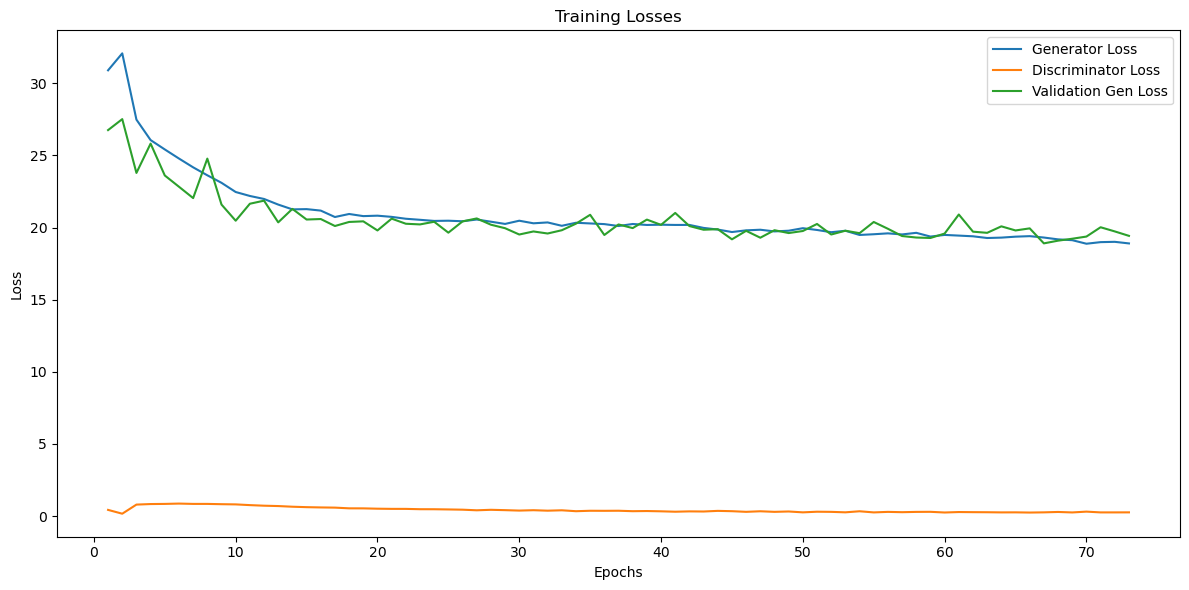

In [30]:
# Plot metrics
plt.figure(figsize=(12, 6))

# Plot Generator and Discriminator Loss
plt.plot(epochs_list, gen_losses, label='Generator Loss')
plt.plot(epochs_list, disc_losses, label='Discriminator Loss')
plt.plot(epochs_list, val_gen_losses, label='Validation Gen Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
epochs_list = np.array(epochs_list)

Podemos ver que o rmse continua caindo. Mais treinamento pode gerar resultados melhores

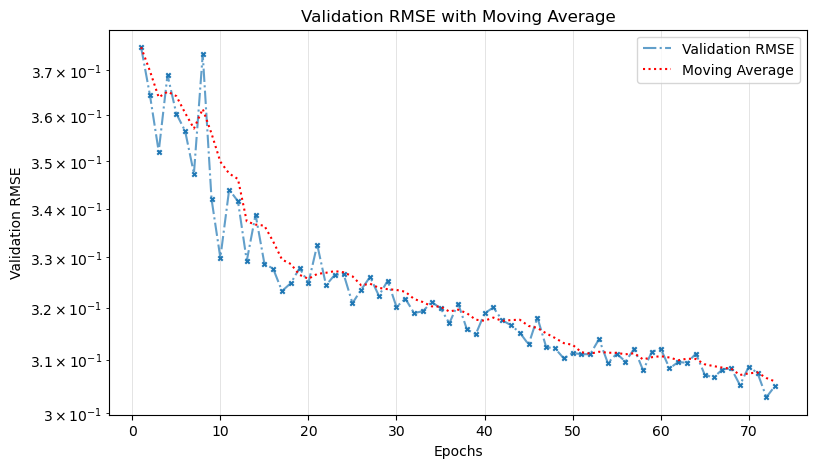

In [32]:
# Calculate moving average using pandas
window_size = 5
val_rmses_series = pd.Series(val_rmses)
moving_avg = val_rmses_series.rolling(window=window_size, min_periods=1).mean()
plt.figure(figsize=(9, 5))

# Plot validation RMSE values
plt.plot(epochs_list, val_rmses, label='Validation RMSE', alpha=0.7, linestyle='dashdot')
plt.scatter(epochs_list, val_rmses, s=10, marker='x')

# Plot the moving average
plt.plot(epochs_list, moving_avg, color='red', linestyle=':', label='Moving Average')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add grid
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE with Moving Average')
plt.legend()

2024-08-05 21:00:47.132930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 108 of 125
2024-08-05 21:00:48.689469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


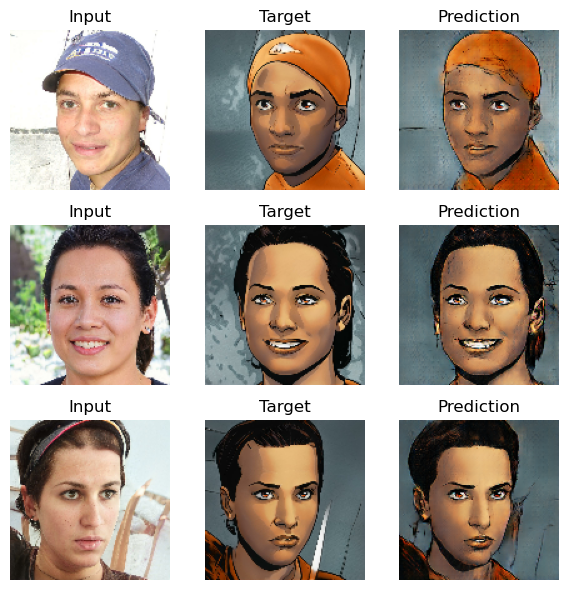

In [33]:
def display_random_images(val_dataset, generator_model, num_samples=3):
    # Get a random batch from the validation dataset
    val_dataset = val_dataset.shuffle(buffer_size=len(val_dataset))
    iterator = iter(val_dataset)

    # Collect a few random samples
    input_images = []
    target_images = []
    predicted_images = []

    for _ in range(num_samples):
        batch = next(iterator)
        input_image, target_image = batch
        input_images.append(input_image.numpy()[0])
        target_images.append(target_image.numpy()[0])
        predicted_image = generator_model(input_image, training=False)
        predicted_images.append(predicted_image.numpy()[0])

    # Plot the images
    fig, axes = plt.subplots(num_samples, 3, figsize=(num_samples*2, num_samples*2))

    for i in range(num_samples):
        # Input image
        axes[i, 0].imshow((input_images[i] + 1) / 2)  # Normalize for display
        axes[i, 0].set_title("Input")
        axes[i, 0].axis('off')

        # Target image
        axes[i, 1].imshow((target_images[i] + 1) / 2)  # Normalize for display
        axes[i, 1].set_title("Target")
        axes[i, 1].axis('off')

        # Predicted image
        axes[i, 2].imshow((predicted_images[i] + 1) / 2)  # Normalize for display
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
display_random_images(val_dataset, generator_model, num_samples=3)

In [34]:
generator_model.save("models/generator.tf")

INFO:tensorflow:Assets written to: models/generator.tf/assets


INFO:tensorflow:Assets written to: models/generator.tf/assets


In [35]:
discriminator_model.save("models/discriminator.tf")

INFO:tensorflow:Assets written to: models/discriminator.tf/assets


INFO:tensorflow:Assets written to: models/discriminator.tf/assets


In [36]:
import pickle
# List of metrics to save
metrics = {
    'epochs': epochs_list,
    'gen_losses': gen_losses,
    'disc_losses': disc_losses,
    'val_gen_losses': val_gen_losses,
    'val_rmses': val_rmses,
    'val_psnrs': val_psnrs
}

# Save metrics to a file
with open('training_history.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics saved successfully!")

Metrics saved successfully!
